In [2]:
# importing necessary modules

import pandas as pd
import numpy as np

df = pd.read_csv("./Salaries.csv")
# read `Salaries` dataset

### 1. Basic Data Exploration: Identify the number of rows and columns in the dataset, determine the data types of each column, and check for missing values in each column.

Since `df` uses the default 0-based pandas's indexing method, we can get the # rows by getting the last index + 1.

In [3]:
print(f"Total # of rows: {df.index[-1] + 1}\nTotal # of columns: {len(df.columns)}")

Total # of rows: 148654
Total # of columns: 13


#### Types of each column:

In [4]:
print(df.columns)

Index(['Id', 'EmployeeName', 'JobTitle', 'BasePay', 'OvertimePay', 'OtherPay',
       'Benefits', 'TotalPay', 'TotalPayBenefits', 'Year', 'Notes', 'Agency',
       'Status'],
      dtype='object')


Id: unique identifier (nominal).

EmployeeName, JobTitle: nominal.

BasePay, OvertimePay, OtherPay, Benefits, TotalPay, TotalPayBenefits: continuous, seince they contains a fractions.

Year: discrete.

Notes, Status: null values, they represent missing or undefined values, they could be nominal.

Agency: nominal.

#### Checking for missing values:

In [5]:
columns_with_mv = df.isna().any()
columns_with_mv.name = "Columns with missing values"
print(columns_with_mv)

Id                  False
EmployeeName        False
JobTitle            False
BasePay              True
OvertimePay          True
OtherPay             True
Benefits             True
TotalPay            False
TotalPayBenefits    False
Year                False
Notes                True
Agency              False
Status               True
Name: Columns with missing values, dtype: bool


 ### 2. Calculate basic statistics mean, median, mode, minimum, and maximum salary, determine the range of salaries, and find the standard deviation.

- Descriptive stat. for numerical attributes:

In [6]:
print(df.drop(columns=["Id"]).describe(include=["number"]))

             BasePay    OvertimePay       OtherPay       Benefits  \
count  148045.000000  148650.000000  148650.000000  112491.000000   
mean    66325.448840    5066.059886    3648.767297   25007.893151   
std     42764.635495   11454.380559    8056.601866   15402.215858   
min      -166.010000      -0.010000   -7058.590000     -33.890000   
25%     33588.200000       0.000000       0.000000   11535.395000   
50%     65007.450000       0.000000     811.270000   28628.620000   
75%     94691.050000    4658.175000    4236.065000   35566.855000   
max    319275.010000  245131.880000  400184.250000   96570.660000   

            TotalPay  TotalPayBenefits           Year  Notes  Status  
count  148654.000000     148654.000000  148654.000000    0.0     0.0  
mean    74768.321972      93692.554811    2012.522643    NaN     NaN  
std     50517.005274      62793.533483       1.117538    NaN     NaN  
min      -618.130000       -618.130000    2011.000000    NaN     NaN  
25%     36168.995000   

- Descriptive stat. for categorical attributes:

In [7]:
print(df.describe(include=["object"]))

       EmployeeName          JobTitle         Agency
count        148654            148654         148654
unique       110811              2159              1
top       Kevin Lee  Transit Operator  San Francisco
freq             13              7036         148654


### 3. Handle missing data by suitable method with explain why you use it.

Well, there are many methods and techniques to deal with missing values, and the most appropriate thing to consider when dealing with missing values is to go back to our stakeholders and ask them how to deal with these missing values.

Let's take a closer look at the missing data, to see the appropriate way to handle each one:

In [8]:
df.loc[:, columns_with_mv].isna().sum()

BasePay           609
OvertimePay         4
OtherPay            4
Benefits        36163
Notes          148654
Status         148654
dtype: int64

Assuming that all missing values are missing completely at random(MCAR) or missing at random(MAR), we can:

- **Row/Column Deletion**:
  This has some repercussions, such as loss of information, impact on statistical calculations, and, of course, it will introduce bias. So, this method is feasible only when large datasets are available, and missing values occur only in a small percentage relative to the dataset size, like in case of `OvertimePay`, `OtherPay` and `BasePay`.

In [9]:
df.dropna(subset=["OvertimePay", "OtherPay"], inplace=True)

    For both `Notes` and `Status` null columns, it may be reasonable to consider removing them, as they do not provide meaningful information for analysis.

In [10]:
df.drop(columns=["Status", "Notes"], inplace=True)

- **Imputation**:
  Imputation involves filling in missing data, typically done by using measures like the mean, median, mode, neighboring values, or predictive modeling techniques.

  When dealing with missing values, it's important to be keep in mind the potential biases introduced by using the mean, especially when a large number of values are missing (e.g. useing the mean for impute missing values in the `Benefits` column), as this could skew the central tendency of the data and lead to inaccuracies. 
  
  In such cases, choosing the median can offer a more robust representation, especially as it is not influenced by outliers. While it's a common practice to calculate subgroup means/medians for imputation, but for simplicity, I'll use the overall mean/median. Additionally, for categorical attributes, relying on the mode is generally the recommended approach.

  The decision between mean and median depends on various factors, one of which involves **assessing skewness**. For example, when examining the skewness of the `BasePay` column and finding a skewness value of approximately 0.42—indicating a nearly symmetric distribution—the choice between mean and median for handling missing values becomes more easy. Given the almost symmetrical nature of the distribution,choosing for the mean to substitute missing values is a suitable choice.

In [11]:
print("β = {0:.2}".format(df["BasePay"].skew()))
df["BasePay"].fillna(df["BasePay"].mean(), inplace=True)

β = 0.42


    Finally, let's handle the missing values in the `Benefits` column of our dataset. Since the number of missing values is relatively large compared to the total size, traditional imputation methods like using the mean or median might not be suitable. Instead, employing the linear regression algorithm seems promising.
    It assumes a linear relationship between the target variable and the other features. By training a linear regression model on the instances where the Benefits column is not missing, we can use this model to predict and impute the missing values based on the observed relationships in the data. This makes it a suitable choice for our scenario.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()

df_not_missing, df_missing = (
    df.loc[df["Benefits"].notna(), df.columns.difference(["Id", "EmployeeName", "Agency", "Year"])],
    df.loc[df["Benefits"].isna(), df.columns.difference(["Id", "EmployeeName", "Agency", "Benefits", "Year"])]
)

df_not_missing.loc[:, "JobTitle"] = df_not_missing["JobTitle"].map(df_not_missing["JobTitle"].value_counts().to_dict())
df_missing.loc[:, "JobTitle"] = df_missing["JobTitle"].map(df_missing["JobTitle"].value_counts().to_dict())


xtrain, xtest, ytrain, ytest = train_test_split(df_not_missing.drop(columns=["Benefits"]), df_not_missing.Benefits)
xtrain = xtrain.sub(xtrain.mean()).div(xtrain.std())
xtest = xtest.sub(xtest.mean()).div(xtest.std())
model.fit(xtrain, ytrain)
ypredict = model.predict(xtest)

print("MSE = {0:.2}".format(mean_squared_error(ytest, ypredict)))

MSE = 3.5e+04


In [13]:
df_missing = df_missing.sub(df_missing.mean()).div(df_missing.std())
ypredict = model.predict(df_missing)
cleaned_benefits = pd.DataFrame(ypredict, index=df_missing.index, columns=["Benefits"])
df = df.combine_first(cleaned_benefits)

Quick check:

In [14]:
df.isna().any()

Agency              False
BasePay             False
Benefits            False
EmployeeName        False
Id                  False
JobTitle            False
OtherPay            False
OvertimePay         False
TotalPay            False
TotalPayBenefits    False
Year                False
dtype: bool

Well, the absence of detailed information regarding data sources, coupled with a lack of guidance on managing missing values and distinguishing between correct and incorrect data values, complicates the data cleaning process. 

Please, refer to *doi* research papers below for more information about how I deal with this task:  
10.20470/JSI.V5I1.178  
10.1111/j.1741-3737.2005.00191

or follow these links:  
https://rb.gy/wjiwmb <br>
https://rb.gy/le1m0o




### 4. **Basic Data Visualization**: Create histograms or bar charts to visualize the distribution of salaries, and use pie charts to represent the proportion of employees in different departments.

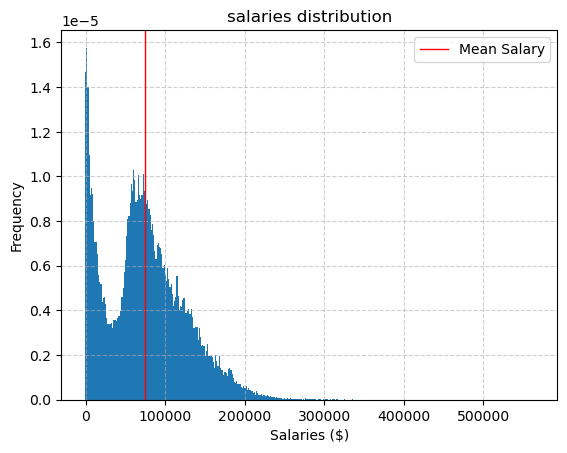

In [15]:
import matplotlib.pyplot as plt 

k = int(np.ceil((df.index[-1] + 1) ** 0.5))
min, max = df.TotalPay.min(), df.TotalPay.max()
R = max - min
class_length = np.ceil(R/k)
classes = [min + class_length * (j - 1) for j in range(k)]

plt.hist(df.TotalPay, bins=classes, density=True)

plt.title("salaries distribution")
plt.ylabel("Frequency")
plt.xlabel("Salaries ($)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.axvline(df.TotalPay.mean(), color='red', linestyle='-', linewidth=1, label='Mean Salary')
plt.legend()

plt.show()

Since there is no explicit department column in the provided dataset, I've opt to use the 'JobTitle' column to infer departmental information.  
However, since there are 2158 unique JobTitles, visualizing each individual title in a pie chart would be overwhelming and lack meaningful insight.  
Thus, the decision is made to prioritize clarity and focus on the top N departments, where N is adjustable, based on employee count

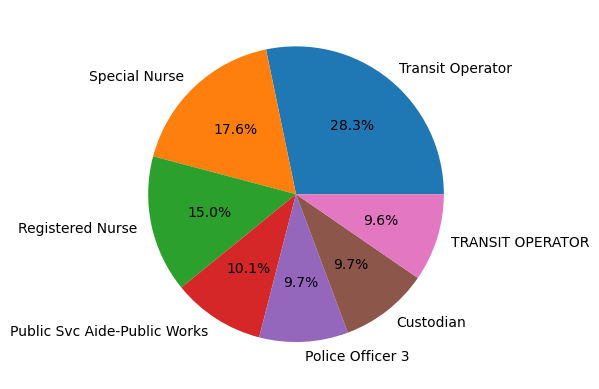

In [16]:
TOP_LARGEST_NDEPARTMENT = 7
top_departments = df['JobTitle'].value_counts().nlargest(TOP_LARGEST_NDEPARTMENT)
plt.pie(top_departments, labels=top_departments.index, startangle=0, autopct="%1.1f%%")
plt.show()

### 6. Grouped Analysis Group the data by one or more columns and calculate summary statistics for each  group, and compare the average salaries across different groups.


In [17]:
grouped_by_year = df.groupby('Year')
grouped_by_job_title = df.groupby('JobTitle')
grouped_by_year_job_title = df.groupby(['Year', 'JobTitle'])

aggregate_functions = {
    'BasePay': 'mean',
    'OvertimePay': 'sum',
    'OtherPay': 'max',
    'TotalPay': 'mean',
    'TotalPayBenefits': 'sum'
}
grouped_by_year.aggregate(aggregate_functions)


,BasePay,OvertimePay,OtherPay,TotalPay,TotalPayBenefits
Year,,,,,
2011,63595.956517,1.638388e+08,400184.25,71744.103871,2.594195e+09
2012,65436.406857,1.846910e+08,245999.41,74113.262265,3.696940e+09
2013,69576.866579,1.986214e+08,202322.37,77611.443142,3.814772e+09
2014,66564.421924,2.059186e+08,342802.63,75471.836912,3.821866e+09


In [18]:
grouped_by_job_title.aggregate(aggregate_functions)

,BasePay,OvertimePay,OtherPay,TotalPay,TotalPayBenefits
JobTitle,,,,,
ACCOUNT CLERK,43300.806506,30975.67,3370.13,44035.664337,3654960.14
ACCOUNTANT,46643.172000,0.00,2782.08,47429.268000,237146.34
ACCOUNTANT INTERN,28732.663958,1172.67,3069.19,29031.742917,1393523.66
"ACPO,JuvP, Juv Prob (SFERS)",62290.780000,0.00,0.00,62290.780000,80266.37
ACUPUNCTURIST,66374.400000,0.00,1220.00,67594.400000,67594.40
...,...,...,...,...,...
X-RAY LABORATORY AIDE,47664.773077,92851.81,5643.93,52705.880385,1370352.89
X-Ray Laboratory Aide,46086.387100,348376.71,7916.20,50823.942700,6952112.32
"YOUTH COMMISSION ADVISOR, BOARD OF SUPERVISORS",52609.910000,0.00,1022.96,53632.870000,53632.87


In [19]:
grouped_by_year_job_title.aggregate(aggregate_functions)

BasePay  OvertimePay  OtherPay  \
Year JobTitle                                                              
2011 ACCOUNT CLERK                   43300.806506     30975.67   3370.13   
     ACCOUNTANT                      46643.172000         0.00   2782.08   
     ACCOUNTANT INTERN               28732.663958      1172.67   3069.19   
     ACUPUNCTURIST                   66374.400000         0.00   1220.00   
     ADMINISTRATIVE ANALYST          63435.628602         0.00  15221.00   
...                                           ...          ...       ...   
2014 Wire Rope Cable Maint Sprv      93904.720000     79173.85  17497.33   
     Worker's Comp Supervisor 1      54505.333333         0.00  12208.04   
     Worker's Compensation Adjuster  69915.985385         0.00  11528.37   
     X-Ray Laboratory Aide           45490.340286    158576.94   5526.45   
     Youth Comm Advisor              32417.420000         0.00   4048.49   

                                          TotalPay  TotalPayBenefits  
Year JobTitle                                                         
2011 ACCOUNT CLERK                    44035.664337        3654960.14  
     ACCOUNTANT                       47429.268000         237146.34  
     ACCOUNTANT INTERN                29031.742917        1393523.66  
     ACUPUNCTURIST                    67594.400000          67594.40  
     ADMINISTRATIVE ANALYST           63954.867527        5947802.68  
...                                            ...               ...  
2014 Wire Rope Cable Maint Sprv      190575.900000         228338.09  
     Worker's Comp Supervisor 1       56689.446667         461786.71  
     Worker's Compensation Adjuster   70636.455385        2527550.84  
     X-Ray Laboratory Aide            51211.566857        2406394.20  
     Youth Comm Advisor               36465.910000          52011.19  

[4136 rows x 5 columns]